<a href="https://colab.research.google.com/github/Taeho-Kim-0322/Deep_Learning_Start/blob/master/%EC%8B%A4%EC%8A%B5_6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 감성분석 실습 ▶ 긍/부 분류

<b>학습 목표:    
- 한국어 자연어처리의 전반적인 FLOW를 이해한다.
- keras.Sequantial 모듈을 이용해 간단한 감성분석 모델을 구현해 학습하고, 학습 결과를 진단한다.</b>









<font color = "red"> 
QUIZ:   
숫자만 인식할 수 있는 기계학습 모델에게 자연어를 인식시키는 방법은? </font>

In [ ]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM 
 

# # 1. 자연어처리 플로우 이해하기

### Step 1. Parsing
- 문장을 음절(character)단위로 쪼개기


In [ ]:
def tokenize(sentence): 
  return [char for char in sentence]

In [ ]:
sentence1 = "시간 가는 줄 알고 봤습니다."
sentence2 = "안보면 후회ㅠㅠ..."
parsed_sent1 = tokenize(sentence1)
parsed_sent2 = tokenize(sentence2)
print("문장 1:", parsed_sent1)
print("문장 2:", parsed_sent2)

문장 1: ['시', '간', ' ', '가', '는', ' ', '줄', ' ', '알', '고', ' ', '봤', '습', '니', '다', '.']
문장 2: ['안', '보', '면', ' ', '후', '회', 'ㅠ', 'ㅠ', '.', '.', '.']


### Step 2. 모델 인풋 만들기


#### 2-1) 음절 사전 만들기
각 음절 캐릭터를 모델이 처리할 수 있는 정수 인덱스로 변환해야 함
- 캐릭터를 정수로 매핑하는 사전 만들기
- 배치 연산을 위해 필요한 Padding([PAD])과 Out of vocabulary([OOV]) 토큰을 항상 맨 앞에 추가해둠

In [ ]:
vocab_dict = {}
vocab_dict["[PAD]"] = 0
vocab_dict["[OOV]"] = 1
i = 2
for word in parsed_sent1:
    if word not in vocab_dict.keys():
        vocab_dict[word] = i
        i += 1
for word in parsed_sent2:
    if word not in vocab_dict.keys():
        vocab_dict[word] = i
        i += 1
print("Vocab Dictionary Example:")
print(vocab_dict)

Vocab Dictionary Example:
{'[PAD]': 0, '[OOV]': 1, '시': 2, '간': 3, ' ': 4, '가': 5, '는': 6, '줄': 7, '알': 8, '고': 9, '봤': 10, '습': 11, '니': 12, '다': 13, '.': 14, '안': 15, '보': 16, '면': 17, '후': 18, '회': 19, 'ㅠ': 20}


#### 2-2) vocab_dict를 이용해 자연어를 정수 인덱스로 바꾸기
- 위에서 만든 vocab_dict를 이용해 잘라놓은 문장을 모델에 태울 수 있는 정수 인덱스로 바꾸기
- 기본적으로 LSTM은 가변적인 문장 길이를 인풋으로 받을 수 있지만, 배치 처리를 위해 <font color="blue">max_seq_len</font>을 정해두고 길이를 통일함    
    - max_seq_len 보다 짧은 문장에는 max_seq_len이 될 때까지 [PAD]에 해당하는 인덱스를 붙여줌
    - max_seq_len 보다 긴 문장은 max_seq_len 개의 토큰만 남기고 자름    
    - tensorflow.keras.preprocessing.sequence의 <font color="blue">pad_sequences</font> 기능 사용

In [ ]:
max_seq_len = 20

input_id1 = [vocab_dict[word] for word in parsed_sent1]
input_id2 = [vocab_dict[word] for word in parsed_sent2]

# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
input_ids = [input_id1, input_id2]
input_ids = pad_sequences(input_ids, maxlen=max_seq_len, value = vocab_dict['[PAD]']) 
print(input_ids)

[[ 0  0  0  0  2  3  4  5  6  4  7  4  8  9  4 10 11 12 13 14]
 [ 0  0  0  0  0  0  0  0  0 15 16 17  4 18 19 20 20 14 14 14]]


### Step3. 모델 만들기

- 임베딩 레이어 : Embedding()
- LSTM : LSTM()
- FC layer : Dense()   
- LSTM을 사용해 문장을 인코딩하고, Fully Connected layer을 두 층 쌓아 최종 output을 생성

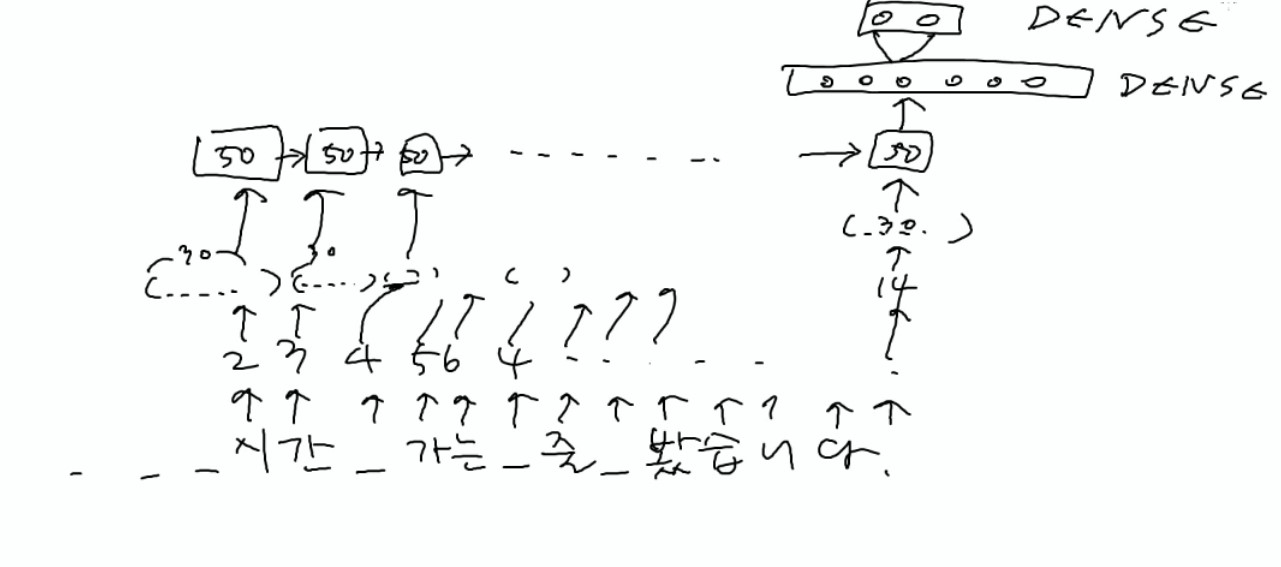

In [ ]:
vocab_size = len(vocab_dict)        # 단어사전 개수
embedding_dim = 30     # 임베딩 차원 ▶ 글자 하나를 몇 차원의 벡터로 변환할지에 대한 hyperparameter
lstm_hidden_dim = 50   # LSTM hidden_size
dense_dim = 32         # FC layer size
batch_size = 2         # batch size

model = Sequential([
    Embedding(vocab_size, embedding_dim), # 정수로 표현된 단어를 embedding_dim 만큼의 벡터로 변환
    LSTM(lstm_hidden_dim),
    Dense(dense_dim, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 30)          630       
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 18,528
Trainable params: 18,528
Non-trainable params: 0
_________________________________________________________________


- <b>model.predict()</b> 메서드를 사용하면 인풋에 대해 모델의 예측값을 얻을 수 있음.   

In [ ]:
scores = model.predict(input_ids)

for i, s in enumerate(scores):
    print("문장 {} → 긍정: {:.2f} / 부정: {:.2f}".format(i, s[0],s[1]))

문장 0 → 긍정: 0.50 / 부정: 0.50
문장 1 → 긍정: 0.50 / 부정: 0.50


# # 2. LSTM으로 감성분석 모델 훈련하기

### Step 0. 학습 데이터 준비하기
<img src = "https://github.com/seungyounglim/temporary/blob/master/image_5.PNG?raw=true">    

- 네이버 영화 감성분석 데이터셋 활용
- 훈련 데이터 150,000건, 테스트 데이터 50,000건

In [ ]:
""" 네이버 영화 리뷰 데이터셋 다운로드 """
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2020-10-15 06:12:07--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.2’

ratings_train.txt.2 100%[===================>]  13.95M  31.5MB/s    in 0.4s    

2020-10-15 06:12:07 (31.5 MB/s) - ‘ratings_train.txt.2’ saved [14628807/14628807]

--2020-10-15 06:12:07--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: 

In [ ]:
""" 데이터 읽어오기 """

with open("ratings_train.txt") as f:
    raw_train = f.readlines()
with open("ratings_test.txt") as f:
    raw_test = f.readlines()
raw_train = [t.split('\t') for t in raw_train[1:]]
raw_test = [t.split('\t') for t in raw_test[1:]]

FULL_TRAIN = []
for line in raw_train:
    FULL_TRAIN.append([line[0], line[1], int(line[2].strip())])
FULL_TEST = []
for line in raw_test:
    FULL_TEST.append([line[0], line[1], int(line[2].strip())])
print("FULL_TRAIN: {}개 (긍정 {}, 부정 {})".format(len(FULL_TRAIN), sum([t[2] for t in FULL_TRAIN]), len(FULL_TRAIN)-sum([t[2] for t in FULL_TRAIN])), FULL_TRAIN[0])
print("FULL_TEST : {}개 (긍정 {}, 부정 {})".format(len(FULL_TEST), sum([t[2] for t in FULL_TEST]), len(FULL_TEST)-sum([t[2] for t in FULL_TEST])), FULL_TEST[0])

FULL_TRAIN: 150000개 (긍정 74827, 부정 75173) ['9976970', '아 더빙.. 진짜 짜증나네요 목소리', 0]
FULL_TEST : 50000개 (긍정 25173, 부정 24827) ['6270596', '굳 ㅋ', 1]


### label 
> 0: 부정

> 1: 긍정

<img src = "https://github.com/seungyounglim/temporary/blob/master/image_6.PNG?raw=true">  
- 시간 관계상 train 중 50,000건을 학습데이터, 10,000건을 검증 데이터로 사용
- test 중 10,000건만 샘플링하여 최종 성능 테스트에 사용

In [ ]:
import random
random.seed(1)
random.shuffle(FULL_TRAIN)
random.shuffle(FULL_TEST)
train = FULL_TRAIN[:50000]
val = FULL_TRAIN[50000:60000]
test = FULL_TEST[:10000]
print("train     : {}개 (긍정 {}, 부정 {})".format(len(train), sum([t[2] for t in train]), len(train)-sum([t[2] for t in train])), train[0])
print("validation: {}개 (긍정 {}, 부정 {})".format(len(val), sum([t[2] for t in val]), len(val)-sum([t[2] for t in val])), val[0])
print("test      : {}개 (긍정 {}, 부정 {})".format(len(test), sum([t[2] for t in test]), len(test)-sum([t[2] for t in test])), test[0])

train     : 50000개 (긍정 24914, 부정 25086) ['7570203', '장쯔이 그때나 지금이나 이뻤다', 1]
validation: 10000개 (긍정 4962, 부정 5038) ['8413570', '거지 발싸개같은 영화도 자막 파일이 넘쳐나는게 허다한데, 왜 이 좋은 영화는 자막을 구할수가 없을까.. 60, 70년대의 프랑스, 이탈리아, 독일의 수작들이 자막이 없어서 수OO이 지난 지금도 일반 대중에게 제대로 알려지지 못했다.', 1]
test      : 10000개 (긍정 5027, 부정 4973) ['1458790', '허우 샤오시엔 작품은 모두 만점!', 1]


## Step 1. Parsing
- Train/ Test의 문장을 음절단위로 파싱하여 train_sentences, test_sentences에 저장해둠.
- categorical_crossentropy loss를 사용하기 위해 정답 라벨은 One-hot encoding 형식으로 저장
   - 부정 -> [1, 0]
   - 긍정 -> [0, 1]

In [ ]:
train_sentences = []
val_sentences = []
test_sentences = []

# 추후 학습/ 테스트를 위해 라벨 정보 저장해둠
train_label_ids = []
val_label_ids = []
test_label_ids = []

print("start tokenizing TRAIN sentences")
for i, line in enumerate(train):
    words = tokenize(line[1])
    train_sentences.append(words)
    if line[2] == 0: # 부정
      train_label_ids.append([1,0])
    else: #긍정
      train_label_ids.append([0,1])

    if (i+1) % 5000 == 0: print("... {}/{} done".format(i+1, len(train)))

print("example:", train_sentences[-1], train_label_ids[-1], "\n")

print("start tokenizing VALIDATION sentences")

for line in val:
    words = tokenize(line[1])
    val_sentences.append(words)
    if line[2] == 0: # 부정
      val_label_ids.append([1,0])
    else: #긍정
      val_label_ids.append([0,1])
print("... done\n")

print("start tokenizing TEST sentences")
for line in test:
    words = tokenize(line[1])
    test_sentences.append(words)
    if line[2] == 0: # 부정
      test_label_ids.append([1,0])
    else: #긍정
      test_label_ids.append([0,1])

print("... done")

start tokenizing TRAIN sentences
... 5000/50000 done
... 10000/50000 done
... 15000/50000 done
... 20000/50000 done
... 25000/50000 done
... 30000/50000 done
... 35000/50000 done
... 40000/50000 done
... 45000/50000 done
... 50000/50000 done
example: ['이', '제', '껏', ' ', '본', ' ', '일', '본', ' ', '영', '화', '중', '에', '서', ' ', '제', '일', ' ', '별', '로', '네', '요', ' ', '3', '명', ' ', '다', ' ', '소', '신', '이', '라', '곤', ' ', '없', '고', ' ', '결', '혼', ' ', '못', '해', ' ', '안', '달', '난', ' ', '여', '자', '들', '이', ' ', '우', '울', '함', '만', ' ', '뿜', '어', '내', '다', ' ', '마', '지', '막', '에', ' ', '일', '본', ' ', '특', '유', '의', ' ', '감', '동', '멘', '트', '로', ' ', '마', '무', '리', ' ', '시', '간', '이', ' ', '아', '깝', '네', '요'] [1, 0] 

start tokenizing VALIDATION sentences
... done

start tokenizing TEST sentences
... done


##Step 2. 모델 인풋 만들기

#### 2-1) 단어사전 만들기
- 훈련 데이터 문장에 있는 음절을 이용해 구축
- (일반적으로는 더 많은 코퍼스에 대해 구축된 사전을 사용하지만, 편의상 훈련셋만으로 진행)

# 실습 MISSION
[CODE] 부분을 채워넣어 단어사전을 만들고 생성된 단어사전의 크기를 확인해보세요. 

In [ ]:
from tqdm import tqdm

vocab_dict = {}
vocab_dict["[PAD]"] = 0
vocab_dict["[OOV]"] = 1
i = 2
for sentence in train_sentences:
    for word in sentence:
        if word not in vocab_dict.keys():
            ## [CODE] ##
            vocab_dict[word] = i
            ############
            i += 1
print("Vocab Dictionary Size:", len(vocab_dict))

Vocab Dictionary Size: 2343


#### 2-2) vocab_dict를 이용해 자연어를 정수 인덱스로 바꾸기

# 실습 MISSION
> 빈칸을 채워봅시다!

음절 단위로 쪼개진 문장들 (tokenized_sentences)을 인풋으로 받아 다음을 처리하는 함수를 만드시오

* 사전에 없는 음절은 [OOV] 인덱스로 처리하기   
* 사전에서 매핑되는 음절은 해당 인덱스로 바꾸기
* max_seq_len만큼 문장 길이 맞추고 이보다 짧은 문장은 [PAD] 인덱스로 패딩하기


In [ ]:
def make_input_ids(tokenized_sentences, max_seq_len = 50):
  
  num_oov = 0 # OOV 발생 개수를 셈
  result_input_ids = [] # result_input_ids : 정수 인덱스로 변환한 문장들의 리스트

  for sentence in tokenized_sentences :
      """ vocab_dict를 사용해 정수로 변환 """ 
      input_ids = []
      for word in sentence:
          if word not in vocab_dict:   ## 사전에 없는 음절은 OOV 처리
              input_ids.append(vocab_dict['[OOV]']) 
              num_oov += 1
          else:                       ## 사전에 있는 음절은?
              input_ids.append(vocab_dict[word]) ##  vocab_dict 사전에서 토큰 찾아서 붙이기
      
      result_input_ids.append(input_ids)
      
  """ max_seq_len을 넘는 문장은 절단, 모자르는 것은 PADDING """
  result_input_ids = pad_sequences(result_input_ids, maxlen=max_seq_len, value= vocab_dict['[PAD]']) ##  padding 하기

  return result_input_ids, num_oov

In [ ]:
# train_sentences 처리
train_input_ids, num_oov = make_input_ids(train_sentences)

print("---- TRAIN ----")
print("... # OOVs     :", num_oov)

---- TRAIN ----
... # OOVs     : 0


In [ ]:
# val_sentences 처리
val_input_ids, num_oov = make_input_ids(val_sentences)

print("---- VALIDATION ----")
print("... # OOVs     :", num_oov)

---- VALIDATION ----
... # OOVs     : 99


In [ ]:
# test_sentences 처리
test_input_ids, num_oov = make_input_ids(test_sentences)

print("---- TEST ----")
print("... # OOVs     :", num_oov)

---- TEST ----
... # OOVs     : 92


#### 2-3) 라벨 리스트를 np.array로 변환
- TIP: tensorflow2.0에서는 numpy array를 인풋으로 받아들임

In [ ]:
train_label_ids = np.array(train_label_ids)
val_label_ids = np.array(val_label_ids)
test_label_ids = np.array(test_label_ids)

## Step3. 모델 만들기

# 실습 MISSION
> 아래 조건에 맞는 모델을 만드시오
 
* embedding 차원은 150
* LSTM hidden size는 100
* Dense의 hidden size는 100, relu activation 사용
* output Dense layer에서는 긍/부정 2개 카테고리를 분류하되 softmax 사용

In [ ]:
vocab_size = len(vocab_dict) 

model = Sequential([
            ####### MISSION 작성 ######
            Embedding(vocab_size, 150), 
            LSTM(100),
            Dense(100, activation='relu'),
            Dense(2, activation='softmax')
            ###########################
])  

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 150)         351450    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 462,152
Trainable params: 462,152
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 훈련하기

#### 4-1) <b>model.compile()</b>을 통해 loss, optimizer 지정

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 4-2) model.fit()을 통해 모델 훈련

In [ ]:
num_epochs = 10
num_batch = 128
history = model.fit(train_input_ids, train_label_ids, epochs=num_epochs, batch_size=num_batch, validation_data=(val_input_ids, val_label_ids), verbose=2) 

test_result = model.evaluate(test_input_ids, test_label_ids, verbose=2)

Epoch 1/10
391/391 - 5s - loss: 0.4899 - accuracy: 0.7624 - val_loss: 0.4411 - val_accuracy: 0.7973
Epoch 2/10
391/391 - 5s - loss: 0.4165 - accuracy: 0.8082 - val_loss: 0.4149 - val_accuracy: 0.8095
Epoch 3/10
391/391 - 5s - loss: 0.3826 - accuracy: 0.8270 - val_loss: 0.4094 - val_accuracy: 0.8097
Epoch 4/10
391/391 - 5s - loss: 0.3597 - accuracy: 0.8409 - val_loss: 0.4018 - val_accuracy: 0.8160
Epoch 5/10
391/391 - 5s - loss: 0.3400 - accuracy: 0.8505 - val_loss: 0.4181 - val_accuracy: 0.8151
Epoch 6/10
391/391 - 5s - loss: 0.3219 - accuracy: 0.8598 - val_loss: 0.4080 - val_accuracy: 0.8215
Epoch 7/10
391/391 - 5s - loss: 0.3050 - accuracy: 0.8692 - val_loss: 0.4330 - val_accuracy: 0.8205
Epoch 8/10
391/391 - 5s - loss: 0.2897 - accuracy: 0.8761 - val_loss: 0.4246 - val_accuracy: 0.8154
Epoch 9/10
391/391 - 5s - loss: 0.2730 - accuracy: 0.8833 - val_loss: 0.4396 - val_accuracy: 0.8217
Epoch 10/10
391/391 - 5s - loss: 0.2579 - accuracy: 0.8916 - val_loss: 0.4620 - val_accuracy: 0.8174

<font color='purple'>🚴‍♀️<i> while training...</i></font>   
<br>
<u> keras RNN API 확인하기</u>
- https://www.tensorflow.org/guide/keras/rnn
- 예) 
  - LSTM의 모든 timestep의 output을 받아오려면 
  - lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)로 설정

#### 4-3) 훈련 결과 진단하기
<font color="red">QUIZ :   
a. 현재 모델에 문제점이 있나요?   
b. 문제가 나타나고 있다면 이에 대한 해결 방안을 제시해 보세요. 
</font>

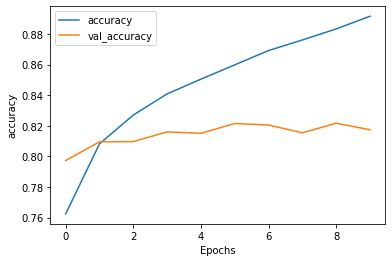

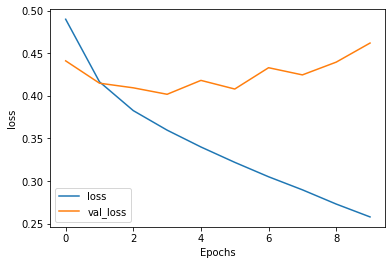

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Step 5. Inference 실행하기

In [ ]:
""" 훈련된 모델로 다시 예측해보기 """

def inference(mymodel, sentence):
  # 1. tokenizer로 문장 파싱
  words = tokenize(sentence)
  input_id = []

  # 2. vocab_dict를 이용해 인덱스로 변환
  for word in words:
    if word in vocab_dict: input_id.append(vocab_dict[word])
    else: input_id.append(vocab_dict["[OOV]"])
  
  # 단일 문장 추론이기 때문에 패딩할 필요가 없음 
  score = mymodel.predict(np.array([input_id])) 

  print("** INPUT:", sentence)
  print("   -> 부정: {:.2f} / 긍정: {:.2f}".format(score[0][0],score[0][1]))

In [ ]:
sentence1 = "시간 가는 줄 알고 봤습니다."
sentence2 = "안보면 후회ㅠㅠ..."
inference(model, sentence1)
inference(model, sentence2)

** INPUT: 시간 가는 줄 알고 봤습니다.
   -> 부정: 0.12 / 긍정: 0.88
** INPUT: 안보면 후회ㅠㅠ...
   -> 부정: 0.37 / 긍정: 0.63


In [ ]:
# 원하는 문장에 대해 추론해 보세요
inference(model, "이런 망작을 나 혼자만 보기엔 아깝지")
inference(model, "이런 꿀잼을 나 혼자만 보기엔 아깝지")
inference(model, "꿀잠 잤습니다")

** INPUT: 이런 망작을 나 혼자만 보기엔 아깝지
   -> 부정: 1.00 / 긍정: 0.00
** INPUT: 이런 꿀잼을 나 혼자만 보기엔 아깝지
   -> 부정: 0.82 / 긍정: 0.18
** INPUT: 꿀잠 잤습니다
   -> 부정: 0.89 / 긍정: 0.11


# # 3. 나만의 모델 만들어보기 

# 실습 MISSION
>  LSTM, Dense layer 등을 자유롭게 활용해서 자신만의 모델을 만들고 
이후 TEST 데이터에 대해 최종 성능을 비교해보세요
</font>
 

In [ ]:
tf.keras.backend.clear_session() 

# 1. 모델 구현하기
model2 = tf.keras.Sequential([
      # MISSION 작성 #
      Embedding(len(vocab_dict), 500),
      LSTM(1000),
      Dense(500, activation='relu'),
      Dense(500, activation='relu'),
      Dense(2, activation='softmax')
      ################                 
]) 


# 2. optimizer, loss 선택하기
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. 모델 훈련하기 (원하는대로 조정해보세요!)
num_epochs = 200
num_batch = 256

# Early_stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3)
history = model2.fit(train_input_ids, train_label_ids, epochs=num_epochs, batch_size=num_batch, validation_data=(val_input_ids, val_label_ids), callbacks=[early_stop], verbose=2)

Epoch 1/200
196/196 - 21s - loss: 0.5243 - accuracy: 0.7404 - val_loss: 0.4544 - val_accuracy: 0.7890
Epoch 2/200
196/196 - 20s - loss: 0.4286 - accuracy: 0.8028 - val_loss: 0.4220 - val_accuracy: 0.8062
Epoch 3/200
196/196 - 20s - loss: 0.3900 - accuracy: 0.8247 - val_loss: 0.4126 - val_accuracy: 0.8083
Epoch 4/200
196/196 - 20s - loss: 0.3591 - accuracy: 0.8408 - val_loss: 0.3973 - val_accuracy: 0.8187
Epoch 5/200
196/196 - 20s - loss: 0.3355 - accuracy: 0.8544 - val_loss: 0.4065 - val_accuracy: 0.8169
Epoch 6/200
196/196 - 20s - loss: 0.3171 - accuracy: 0.8633 - val_loss: 0.4191 - val_accuracy: 0.8168
Epoch 7/200
196/196 - 20s - loss: 0.2944 - accuracy: 0.8737 - val_loss: 0.4269 - val_accuracy: 0.8173


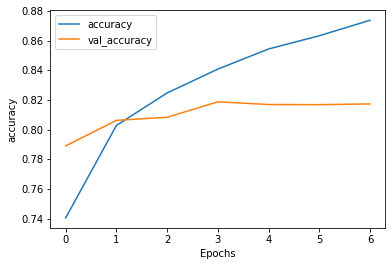

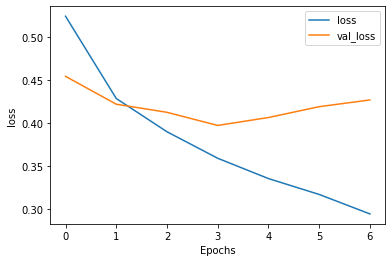

In [ ]:
# 4. 모델 진단하기

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# 5. 테스트 데이터에 대해 평가하기

model2.evaluate(test_input_ids, test_label_ids, verbose=2)

313/313 - 3s - loss: 0.4347 - accuracy: 0.8097


[0.434659481048584, 0.8097000122070312]

In [ ]:
# 샘플 예제에 대해 추론해 보세요 

inference(model2, "물이 반도 안남았다")  #부정
inference(model2, "물이 반이나 남았다")  #긍정
inference(model2, "죄송하지만 혹시 실례가 안된다면 꺼져주실수 있으신지ㅎㅎ?") #부정
inference(model2, "잘하는 짓이다") #부정
inference(model2, "가게 외관은 구린데 맛은 ㅇㅈ") #긍정
inference(model2, "ㄷㄷ 간만에 갓띵작 ㄷㄷㄷ") #긍정
inference(model2, "주인공 커여워 ㅠㅠ") #긍정
inference(model2, "OTL") #부정


** INPUT: 물이 반도 안남았다
   -> 부정: 0.92 / 긍정: 0.08
** INPUT: 물이 반이나 남았다
   -> 부정: 0.50 / 긍정: 0.50
** INPUT: 죄송하지만 혹시 실례가 안된다면 꺼져주실수 있으신지ㅎㅎ?
   -> 부정: 0.66 / 긍정: 0.34
** INPUT: 잘하는 짓이다
   -> 부정: 0.49 / 긍정: 0.51
** INPUT: 가게 외관은 구린데 맛은 ㅇㅈ
   -> 부정: 0.84 / 긍정: 0.16
** INPUT: ㄷㄷ 간만에 갓띵작 ㄷㄷㄷ
   -> 부정: 0.21 / 긍정: 0.79
** INPUT: 주인공 커여워 ㅠㅠ
   -> 부정: 0.52 / 긍정: 0.48
** INPUT: OTL
   -> 부정: 0.61 / 긍정: 0.39
